# Churn Prediction

Churn prediction is big business. It minimizes customer defection by predicting which customers are likely to cancel a subscription to a service. Though originally used within the telecommunications industry, it has become common practice across banks, ISPs, insurance firms, and other verticals.

The prediction process is heavily data driven and often utilizes advanced machine learning techniques. In this post, we'll take a look at what types of customer data are typically used, do some preliminary analysis of the data, and generate churn prediction models - all with PySpark and its machine learning frameworks. We'll also discuss the differences between two Apache Spark version 1.6.0 frameworks, MLlib and ML.

In [275]:
# Disable warnings, set Matplotlib inline plotting and load Pandas package
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import pandas as pd

## Fetching and Importing Churn Data

In [276]:
CV_data =pd.read_csv('./data/churn-bigml-80.csv')
                         
# inferSchema (default false): infers the input schema automatically from data. It requires one extra pass over the data.

final_test_data = pd.read_csv('./data/churn-bigml-20.csv')
                          
CV_data.head(5)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [277]:
CV_data.shape

(2666, 20)

In [278]:
CV_data.groupby('Churn').count()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
Churn,,,,,,,,,,,,,,,,,,,
False,2278,2278,2278,2278,2278,2278,2278,2278,2278,2278,2278,2278,2278,2278,2278,2278,2278,2278,2278
True,388,388,388,388,388,388,388,388,388,388,388,388,388,388,388,388,388,388,388


## Summary Statistics

Spark DataFrames include some [built-in functions](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame) for statistical processing. The _describe()_ function performs summary statistics calculations on all numeric columns, and returns them as a DataFrame. 

In [279]:
# CV_data.describe().transpose()

## Deal with missing data

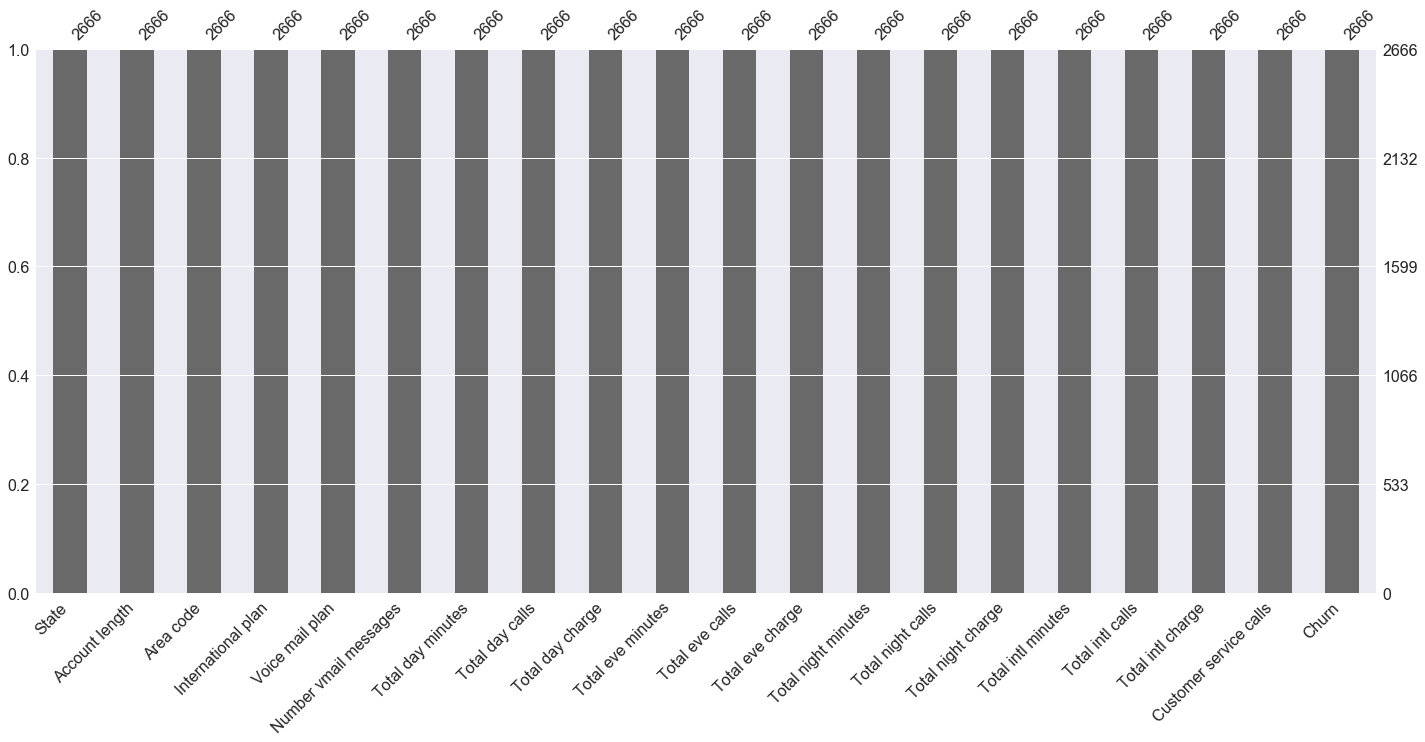

In [280]:
import missingno as msno
columns = CV_data.columns
msno.bar(CV_data[columns])

**Conclusion: No missing data**

## Correlations and Data Preparation

In [281]:
import seaborn as sns

###  Data Type

In [282]:
categorical_columns = [col for col in CV_data.columns.values if CV_data[col].dtype == 'O']
y_label = [col for col in CV_data.columns.values if CV_data[col].dtype == 'bool']
# dataframe with categorical features
cat = CV_data[categorical_columns]
# dataframe with numerical features
num = CV_data.drop(columns = categorical_columns, axis = 1)                
num = num.drop(columns = y_label, axis = 1)                  
# num is dataframe about numeric features
#sns.pairplot(num)

### y_label

<font color=red>Debug: y_label 是booln型，不可以用像object一样，if = "False" = 1 的形式，因为在程序看来，是都不等的</font>

In [283]:
y_label = CV_data['Churn'].apply(lambda x: int(x))

In [286]:
y_label.to_frame().head()

,Churn
0,0
1,0
2,0
3,0
4,0


### Numeric data

In [287]:
CV_data['State'].dtype

dtype('O')

In [288]:
num.head()

,Account length,Area code,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,128,415,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,107,415,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,137,415,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,84,408,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,75,415,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


In [289]:
import numpy as np
import matplotlib.pyplot as plt

Notice that correlation map cannot include object value

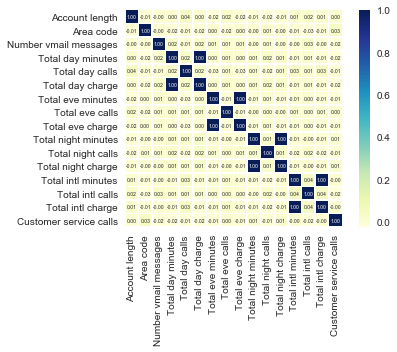

In [290]:
#Churn correlation matrix
corr_matrix = num.corr()
cols = num.columns
cm = np.corrcoef(num[cols].values.T)
sns.set(font_scale=1)
sns.heatmap(corr_matrix, cbar=True, annot=True, linewidths=.5,cmap="YlGnBu",annot_kws={"size": 5},square=True, fmt='.2f',yticklabels=cols.values, xticklabels=cols.values)
plt.show()

From the above, it shows that correlation between Total day charge and total day minutes is 1, so create a new feature called average minure charge.

the same happens to total eve charge and total eve minuts, total night charge and total night minutes, total intl charge and total intl charge.

In [291]:
num['average day charge'] = num['Total day minutes'] / num['Total day charge']
num['average eve charge'] = num['Total eve minutes'] / num['Total eve charge']
num['average night charge'] = num['Total night minutes'] / num['Total night charge']
num['average intl charge'] = num['Total intl minutes'] / num['Total intl charge']
num = num.drop(columns = ['Total day minutes','Total eve minutes','Total night minutes','Total intl minutes',
               'Total day charge','Total eve charge','Total night charge','Total intl charge'])

In [292]:
num.head()

,Account length,Area code,Number vmail messages,Total day calls,Total eve calls,Total night calls,Total intl calls,Customer service calls,average day charge,average eve charge,average night charge,average intl charge
0,128,415,25,110,99,91,3,1,5.881961,11.764005,22.225250,3.703704
1,107,415,26,123,103,103,3,1,5.882781,11.762936,22.218341,3.702703
2,137,415,0,114,110,104,5,0,5.882069,11.766990,22.213115,3.708207
3,84,408,0,71,88,89,7,2,5.882122,11.768061,22.223476,3.707865
4,75,415,0,113,122,121,3,3,5.882145,11.760508,22.223543,3.699634


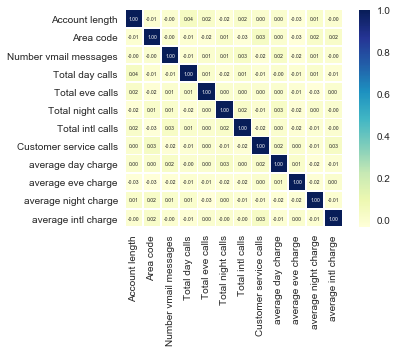

<Figure size 2880x2880 with 0 Axes>

In [293]:
#Churn correlation matrix
corr_matrix = num.corr()
cols = num.columns
cm = np.corrcoef(num[cols].values.T)
sns.set(font_scale=1)
sns.heatmap(corr_matrix, cbar=True, annot=True, linewidths=.5,cmap="YlGnBu",annot_kws={"size": 5},square=True, fmt='.2f',yticklabels=cols.values, xticklabels=cols.values)
plt.figure(figsize=(40,40))
plt.show()

### Scaling

**<font color='red'>Debug: 用除法生成新变量之后，会出现缺省值</font>**

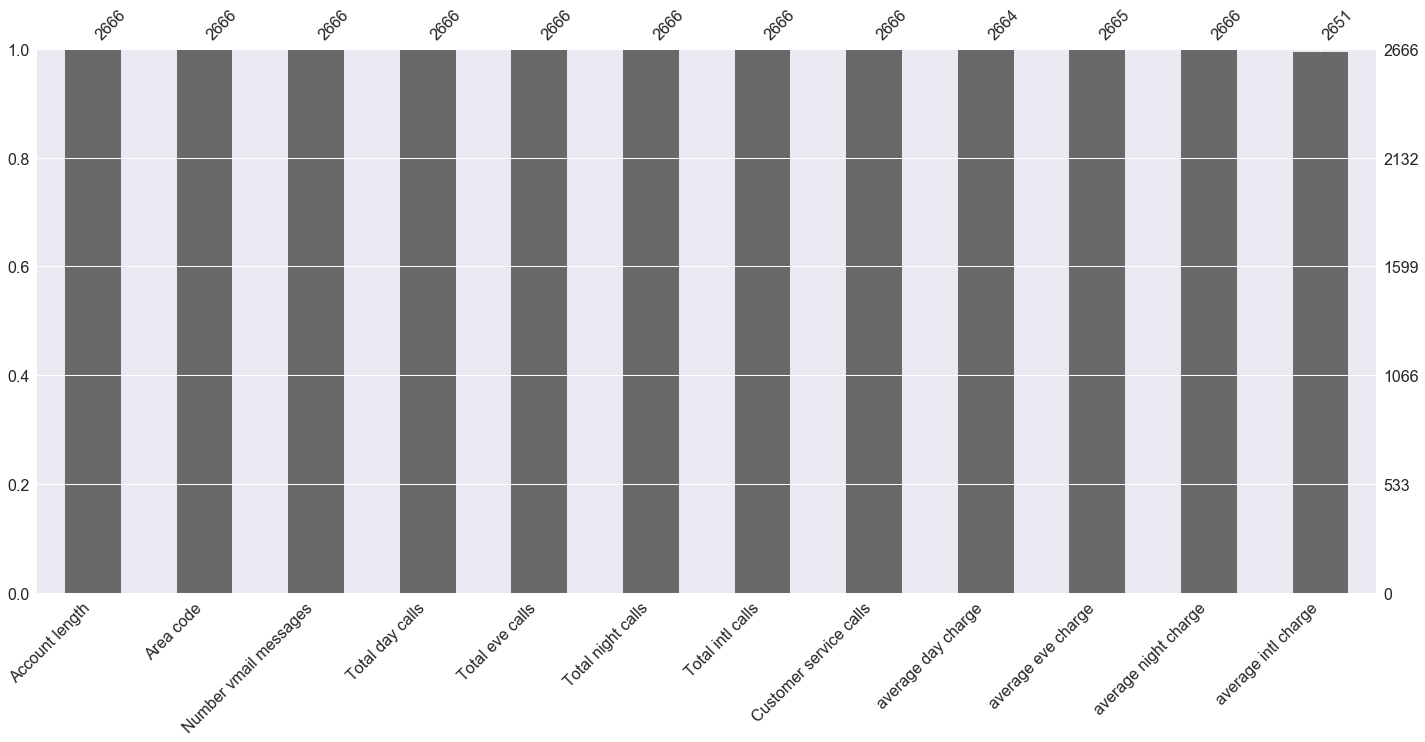

In [294]:
columns = num.columns
msno.bar(num[columns])

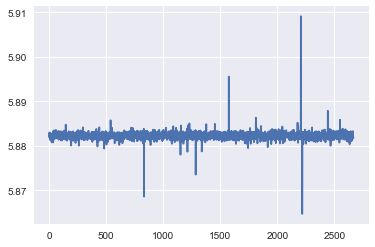

In [295]:
plt.plot(num['average day charge'])

In [296]:
num = num.fillna(num['average day charge'].mean())
num = num.fillna(num['average eve charge'].mean())
num = num.fillna(num['average intl charge'].mean())

In [297]:
# columns = num.columns
# msno.bar(num[columns])

In [298]:
import sklearn.preprocessing as preprocessing

In [299]:
scaler = preprocessing.StandardScaler()
num1 = num.drop(['Area code'],axis=1)
print (num1.columns)

Index(['Account length', 'Number vmail messages', 'Total day calls',
       'Total eve calls', 'Total night calls', 'Total intl calls',
       'Customer service calls', 'average day charge', 'average eve charge',
       'average night charge', 'average intl charge'],
      dtype='object')


In [300]:
num1.head()

,Account length,Number vmail messages,Total day calls,Total eve calls,Total night calls,Total intl calls,Customer service calls,average day charge,average eve charge,average night charge,average intl charge
0,128,25,110,99,91,3,1,5.881961,11.764005,22.225250,3.703704
1,107,26,123,103,103,3,1,5.882781,11.762936,22.218341,3.702703
2,137,0,114,110,104,5,0,5.882069,11.766990,22.213115,3.708207
3,84,0,71,88,89,7,2,5.882122,11.768061,22.223476,3.707865
4,75,0,113,122,121,3,3,5.882145,11.760508,22.223543,3.699634


In [301]:
for i in num1.columns:
    scale_param = scaler.fit(num1[[i]])
    #print(scale_param)
    num1[i] = scaler.fit_transform(num[[i]],scale_param)
num1.head()

,Account length,Number vmail messages,Total day calls,Total eve calls,Total night calls,Total intl calls,Customer service calls,average day charge,average eve charge,average night charge,average intl charge
0,0.692163,1.247508,0.484868,-0.050781,-0.469031,-0.597527,-0.429172,-0.276822,0.014900,0.402666,-0.070614
1,0.161278,1.320985,1.135375,0.147654,0.149054,-0.597527,-0.429172,0.532952,0.005521,-0.452165,-0.076752
2,0.919686,-0.589414,0.685024,0.494917,0.200561,0.216894,-1.191955,-0.170897,0.041106,-1.098729,-0.043000
3,-0.420168,-0.589414,-1.466653,-0.596479,-0.572045,1.031314,0.333610,-0.118374,0.050503,0.183244,-0.045094
4,-0.647691,-0.589414,0.634985,1.090224,1.076181,-0.597527,1.096392,-0.095093,-0.015797,0.191546,-0.095573


In [302]:
# area code is categorical data actually, so is should be processed as dummy data.

In [303]:
Areacode_dummies = pd.get_dummies(num['Area code'],prefix = 'Area_code')
Areacode_dummies.head()

,Area_code_408,Area_code_415,Area_code_510
0,0,1,0
1,0,1,0
2,0,1,0
3,1,0,0
4,0,1,0


In [304]:
Areacode_dummies['Area_code_408'].dtype
# Unsigned integer (0 to 255) 无符号整数

dtype('uint8')

In [305]:
for i in Areacode_dummies.columns:
    Areacode_dummies[i] = np.int64(Areacode_dummies[i])

In [306]:
Areacode_dummies['Area_code_408'].dtype

dtype('int64')

**<font color = 'red'>Debug: 合并之后，dummy值变成了NaN</font>**

join = 'inner'

In [307]:
num['Total day calls'].dtype
#Integer (-9223372036854775808 to 9223372036854775807)

dtype('int64')

In [308]:
num = pd.concat([num1,Areacode_dummies],axis=1,join='inner')
print (num.shape)
Areacode_dummies['Area_code_408'].dtype

(2666, 14)


dtype('int64')

In [309]:
num.head()

,Account length,Number vmail messages,Total day calls,Total eve calls,Total night calls,Total intl calls,Customer service calls,average day charge,average eve charge,average night charge,average intl charge,Area_code_408,Area_code_415,Area_code_510
0,0.692163,1.247508,0.484868,-0.050781,-0.469031,-0.597527,-0.429172,-0.276822,0.014900,0.402666,-0.070614,0,1,0
1,0.161278,1.320985,1.135375,0.147654,0.149054,-0.597527,-0.429172,0.532952,0.005521,-0.452165,-0.076752,0,1,0
2,0.919686,-0.589414,0.685024,0.494917,0.200561,0.216894,-1.191955,-0.170897,0.041106,-1.098729,-0.043000,0,1,0
3,-0.420168,-0.589414,-1.466653,-0.596479,-0.572045,1.031314,0.333610,-0.118374,0.050503,0.183244,-0.045094,1,0,0
4,-0.647691,-0.589414,0.634985,1.090224,1.076181,-0.597527,1.096392,-0.095093,-0.015797,0.191546,-0.095573,0,1,0


### Categorical data

transform the categorical data into numeric as required by the machine learning routines, using One-hot code.

In [310]:
cat.columns

Index(['State', 'International plan', 'Voice mail plan'], dtype='object')

In [311]:
cat.head(3)

,State,International plan,Voice mail plan
0,KS,No,Yes
1,OH,No,Yes
2,NJ,No,No


In [312]:
# One-Hot
State_dummies = pd.get_dummies(cat['State'],prefix = 'State')
# 0-1
cat['International plan'] = cat['International plan'].apply(lambda x: 0 if x=='No' else 1)
cat['Voice mail plan'] = cat['Voice mail plan'].apply(lambda x: 0 if x=='No' else 1)
cat.head()

,State,International plan,Voice mail plan
0,KS,0,1
1,OH,0,1
2,NJ,0,0
3,OH,1,0
4,OK,1,0


In [313]:
cat = cat.drop(['State'],axis=1)
cat = pd.concat([cat,State_dummies],axis=1,join='inner')
cat.head()

,International plan,Voice mail plan,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,...,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [317]:
CV_data = pd.concat([cat,num,y_label],axis=1,join='inner')

In [318]:
CV_data.head()

,International plan,Voice mail plan,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,...,Total intl calls,Customer service calls,average day charge,average eve charge,average night charge,average intl charge,Area_code_408,Area_code_415,Area_code_510,Churn
0,0,1,0,0,0,0,0,0,0,0,...,-0.597527,-0.429172,-0.276822,0.014900,0.402666,-0.070614,0,1,0,0
1,0,1,0,0,0,0,0,0,0,0,...,-0.597527,-0.429172,0.532952,0.005521,-0.452165,-0.076752,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0.216894,-1.191955,-0.170897,0.041106,-1.098729,-0.043000,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,...,1.031314,0.333610,-0.118374,0.050503,0.183244,-0.045094,1,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,-0.597527,1.096392,-0.095093,-0.015797,0.191546,-0.095573,0,1,0,0


In [319]:
CV_data.groupby('Churn').count()

,International plan,Voice mail plan,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,...,Total night calls,Total intl calls,Customer service calls,average day charge,average eve charge,average night charge,average intl charge,Area_code_408,Area_code_415,Area_code_510
Churn,,,,,,,,,,,,,,,,,,,,,
0,2278,2278,2278,2278,2278,2278,2278,2278,2278,2278,...,2278,2278,2278,2278,2278,2278,2278,2278,2278,2278
1,388,388,388,388,388,388,388,388,388,388,...,388,388,388,388,388,388,388,388,388,388


In [320]:
CV_data.to_csv('processed_data.csv')